## 基础处理

In [1]:
# 设置颜色集
defined_cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                '#aaffc3', '#808000', '#ffd8bl', '#000075', '#808080']

In [2]:
# 加载包
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cell2location
import mygene

from cell2location.utils.filtering import filter_genes
from matplotlib import rcParams
from cell2location.models import RegressionModel

# enables correct plotting of text for PDFs
mpl.rcParams['pdf.fonttype'] = 42 

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 设置结果的输出路径
from os import makedirs
from os.path import exists

results_folder = '/home/zhangyinan/TXL_new/4_cell2location/Integrate/Control5_Model2_Treatment3/result/celltype'
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## 空转数据预处理

In [ ]:
## 空转数据

# 数据读取
adata_vis = sc.read_visium('/home/zhangyinan/TXL_new/1_basic_data_processing/Control5_Model2_Treatment3/data/control5_model2_treatment3')
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]
# adata_vis.obs['sample'] = "control5_model2_treatment3"
adata_vis.var.head()

# 将基因重命名为ENSEMBL ID,以便在单细胞和空间数据之间正确匹配
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

# 去除解卷积不需要的线粒体基因
# find mitochondria-encoded (MT) genes
adata_vis.var['Mt_gene'] = [gene.startswith('Mt-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['Mt'] = adata_vis[:, adata_vis.var['Mt_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['Mt_gene'].values]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## 单细胞数据预处理

### 读取单细胞数据

In [5]:
# 读取单细胞数据
adata_ref = sc.read_h5ad("/home/zhangyinan/TXL_new/2_annotation/scRNA_annotation/result/Integrate/Integrate.h5ad")

In [6]:
adata_ref.var

,features
ENSRNOG00000066169,ENSRNOG00000066169
Irgq,Irgq
Doc2g,Doc2g
Ceacam16,Ceacam16
ENSRNOG00000068698,ENSRNOG00000068698
...,...
Pabpn1l,Pabpn1l
5S-rRNA.95,5S-rRNA.95
ENSRNOG00000066903,ENSRNOG00000066903
AABR07034923.1,AABR07034923.1


### 定义函数，symbol基因转化为ensemble ID

In [7]:
## 定义函数，将单细胞数据的scRNA数据的symbol基因转化为ensemble ID
mg = mygene.MyGeneInfo()

def symbol_gene_ensembol(symbol_ids):
    uni_dict = {}
    for i in mg.querymany(symbol_ids, scopes="symbol", fields="ensembl.gene", species='rat'):
        try:
            uni_dict.update({i['query']: i['ensembl']['gene']})
            print('1')
        except:
            continue
    return uni_dict

def symbol_gene_ensembol_pd(df, col_gene, symol_dict=None):
    sembol_genes = list(df[col_gene])
    
    # 如果没有传入预先构建的字典，则调用 symbol_gene_ensembol 来构建字典
    if symol_dict is None:
        symol_dict = symbol_gene_ensembol(sembol_genes)
    
    # 使用 apply 方法，若找不到 ENSEMBL_ID，则填充原 symbolID
    df.insert(1, 'ENSEMBL_ID', df[col_gene].apply(lambda x: symol_dict.get(x, x)))  # 如果没有找到对应的 ENSEMBL_ID，则返回原 symbolID
    
    return df

In [8]:
# 导入时，var.feature是NA值
adata_ref.var['var.features'] = adata_ref.var.index

adata_ref.var= symbol_gene_ensembol_pd(adata_ref.var, 'var.features', None)
adata_ref.var.head()

# 将ensemblID转化为列名
adata_ref.var.set_index(adata_ref.var['ENSEMBL_ID'], inplace=True)
# 移除索引的列名
adata_ref.var.index.name = None  

# 保留索引基因名为唯一值
adata_ref.var_names_make_unique()
adata_ref.var

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-21155...done.
Finished.
901 input query terms found dup hits:
	[('Ptprh', 2), ('Igsf6', 2), ('Selenow', 2), ('Aldh3b2', 2), ('Tmem80', 2), ('Ceacam18', 2), ('Zfp78
5539 input query terms found no hit:
	['ENSRNOG00000066169', 'ENSRNOG00000068698', 'AC118165.1', 'AC099294.1', 'ENSRNOG00000070886', 'SNOR
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
1
1
1
1
1
1

,features,ENSEMBL_ID,var.features
ENSRNOG00000066169,ENSRNOG00000066169,ENSRNOG00000066169,ENSRNOG00000066169
ENSRNOG00000070901,Irgq,ENSRNOG00000070901,Irgq
ENSRNOG00000018029,Doc2g,ENSRNOG00000018029,Doc2g
ENSRNOG00000031391,Ceacam16,ENSRNOG00000031391,Ceacam16
ENSRNOG00000068698,ENSRNOG00000068698,ENSRNOG00000068698,ENSRNOG00000068698
...,...,...,...
ENSRNOG00000029558,Pabpn1l,ENSRNOG00000029558,Pabpn1l
5S-rRNA.95,5S-rRNA.95,5S-rRNA.95,5S-rRNA.95
ENSRNOG00000066903,ENSRNOG00000066903,ENSRNOG00000066903,ENSRNOG00000066903
AABR07034923.1,AABR07034923.1,AABR07034923.1,AABR07034923.1


## 参考细胞类型特征的估计（NB回归）

In [10]:
adata_ref.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,integrated_snn_res.0.5,seurat_clusters,sc_celltype,hm_celltype,_indices,_scvi_batch
mMCAO_contra_AAACCTGAGACCGGAT-1,mMCAO,1785.0,1039,0.112045,2935.0,1047,11,11,Neurons,GABAergic Neurons,0,1
mMCAO_contra_AAACCTGAGCCAACAG-1,mMCAO,1248.0,836,0.000000,2781.0,929,8,8,Oligodendrocytes,Oligodendrocyte Precursor Cells,1,1
mMCAO_contra_AAACCTGAGCGAAGGG-1,mMCAO,4341.0,1980,0.023036,3884.0,1980,3,3,Neurons,Glutamatergic Neurons,2,1
mMCAO_contra_AAACCTGAGCGTTGCC-1,mMCAO,2851.0,1542,0.000000,3082.0,1542,11,11,Neurons,GABAergic Neurons,3,1
mMCAO_contra_AAACCTGAGCTGAACG-1,mMCAO,3421.0,1915,0.000000,3421.0,1914,2,2,Neurons,GABAergic Neurons,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
Sham_R_TTTGTCATCCTCTAGC-1,Sham,4317.0,2174,0.000000,2915.0,2025,2,2,Neurons,GABAergic Neurons,73816,0
Sham_R_TTTGTCATCCTGTAGA-1,Sham,3342.0,1614,0.059844,2705.0,1608,5,5,Neurons,Glutamatergic Neurons,73817,0
Sham_R_TTTGTCATCCTTCAAT-1,Sham,2433.0,1202,0.164406,2373.0,1202,3,3,Neurons,Glutamatergic Neurons,73818,0
Sham_R_TTTGTCATCTGCAGTA-1,Sham,5559.0,2218,0.017989,2783.0,1678,7,7,Neurons,Glutamatergic Neurons,73819,0


In [ ]:
# 参考细胞类型特征的估计（NB回归）
cell2location.models.RegressionModel.setup_anndata(adata = adata_ref,
                        batch_key='orig.ident',
                        labels_key='hm_celltype')

# 创建回归模型
mod = RegressionModel(adata_ref)

# 训练模型
mod.train(max_epochs=250)

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve

Epoch 1/250:   0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
# 特征数据提取
adata_ref = mod.export_posterior(adata_ref)

# 信息覆盖空间数据
adata_ref = mod.export_posterior(adata_ref, use_quantiles = True, add_to_varm = ["q05","q50", "q95", "q0001"])

Sampling global variables, sample: 100%|██████████| 999/999 [00:12<00:00, 79.55it/s]


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'/home/zhangyinan/TXL_new/data_and_result/Control3_Model1_Treatment2/3_cell2location/reference_signatures/sc.h5ad'

In [4]:
# 读取模型
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File                                                                                                      
         /home/zhangyinan/TXL_new/4_cell2location/Integrate/Control5_Model2_Treatment3/result/celltype/reference_si
         gnatures/model.pt already downloaded                                                                      


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, ma

Epoch 1/271:   0%|          | 1/271 [00:00<01:01,  4.41it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/271:   0%|          | 1/271 [00:00<01:04,  4.17it/s, v_num=1]


In [7]:
# 估计每种细胞类型中每个基因的表达
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']

In [8]:
# 提取单细胞和空转数据的共有基因
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

## 将单细胞数据提取出的特征对空间细胞进行训练

In [ ]:
# 将单细胞数据提取出的特征对空间细胞进行训练
cell2location.models.Cell2location.setup_anndata(adata = adata_vis)

# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df = inf_aver,
    N_cells_per_location = 30,
    detection_alpha = 20
)

# training cell2loaction
mod.train(max_epochs = 10,
          batch_size = None,
        #   batch_size = 2500,
          train_size = 1,
         )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2/10:  10%|█         | 1/10 [00:13<01:59, 13.30s/it, v_num=1]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 3/10:  20%|██        | 2/10 [00:24<01:36, 12.01s/it, v_num=1, elbo_train=4.86e+7]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 4/10:  30%|███       | 3/10 [00:35<01:21, 11.69s/it, v_num=1, elbo_train=4.86e+7]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 5/10:  40%|████      | 4/10 [00:46<01:07, 11.18s/it, v_num=1, elbo_train=4.84e+7]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 6/10:  50%|█████     | 5/10 [00:57<00:55, 11.13s/it, v_num=1, elbo_train=4.83e+7]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 7/10:  60%|██████    | 6/10 [01:07<00:43, 10.82s/it, v_num=1, elbo_train=4.81e+7]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 8/10:  70%|███████   | 7/10 [01:18<00:32, 10.88s/it, v_num=1, elbo_train=4.82e+7]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 9/10:  80%|████████  | 8/10 [01:28<00:21, 10.63s/it, v_num=1, elbo_train=4.81e+7]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 10/10:  90%|█████████ | 9/10 [01:38<00:10, 10.53s/it, v_num=1, elbo_train=4.82e+7]

/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 10/10: 100%|██████████| 10/10 [01:50<00:00, 10.80s/it, v_num=1, elbo_train=4.79e+7]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [01:50<00:00, 11.02s/it, v_num=1, elbo_train=4.79e+7]


In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [02:24<00:00,  6.94it/s]


'/home/zhangyinan/TXL_new/data_and_result/Control3_Model1_Treatment2/3_cell2location/cell2location_map/sp.h5ad'

In [5]:
# 读取跑出来的空转数据
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)
# adata_vis = sc.read('/home/zhangyinan/TXL_new/data_and_result/Control3_Model1_Treatment2/3_cell2location/cell2location_map/sp.h5ad')

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File                                                                                                      
         /home/zhangyinan/TXL_new/4_cell2location/Integrate/Control5_Model2_Treatment3/result/celltype/cell2locatio
         n_map/model.pt already downloaded                                                                         


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, ma

Epoch 1/30000:   0%|          | 1/30000 [00:00<48:21, 10.34it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<50:37,  9.88it/s, v_num=1]


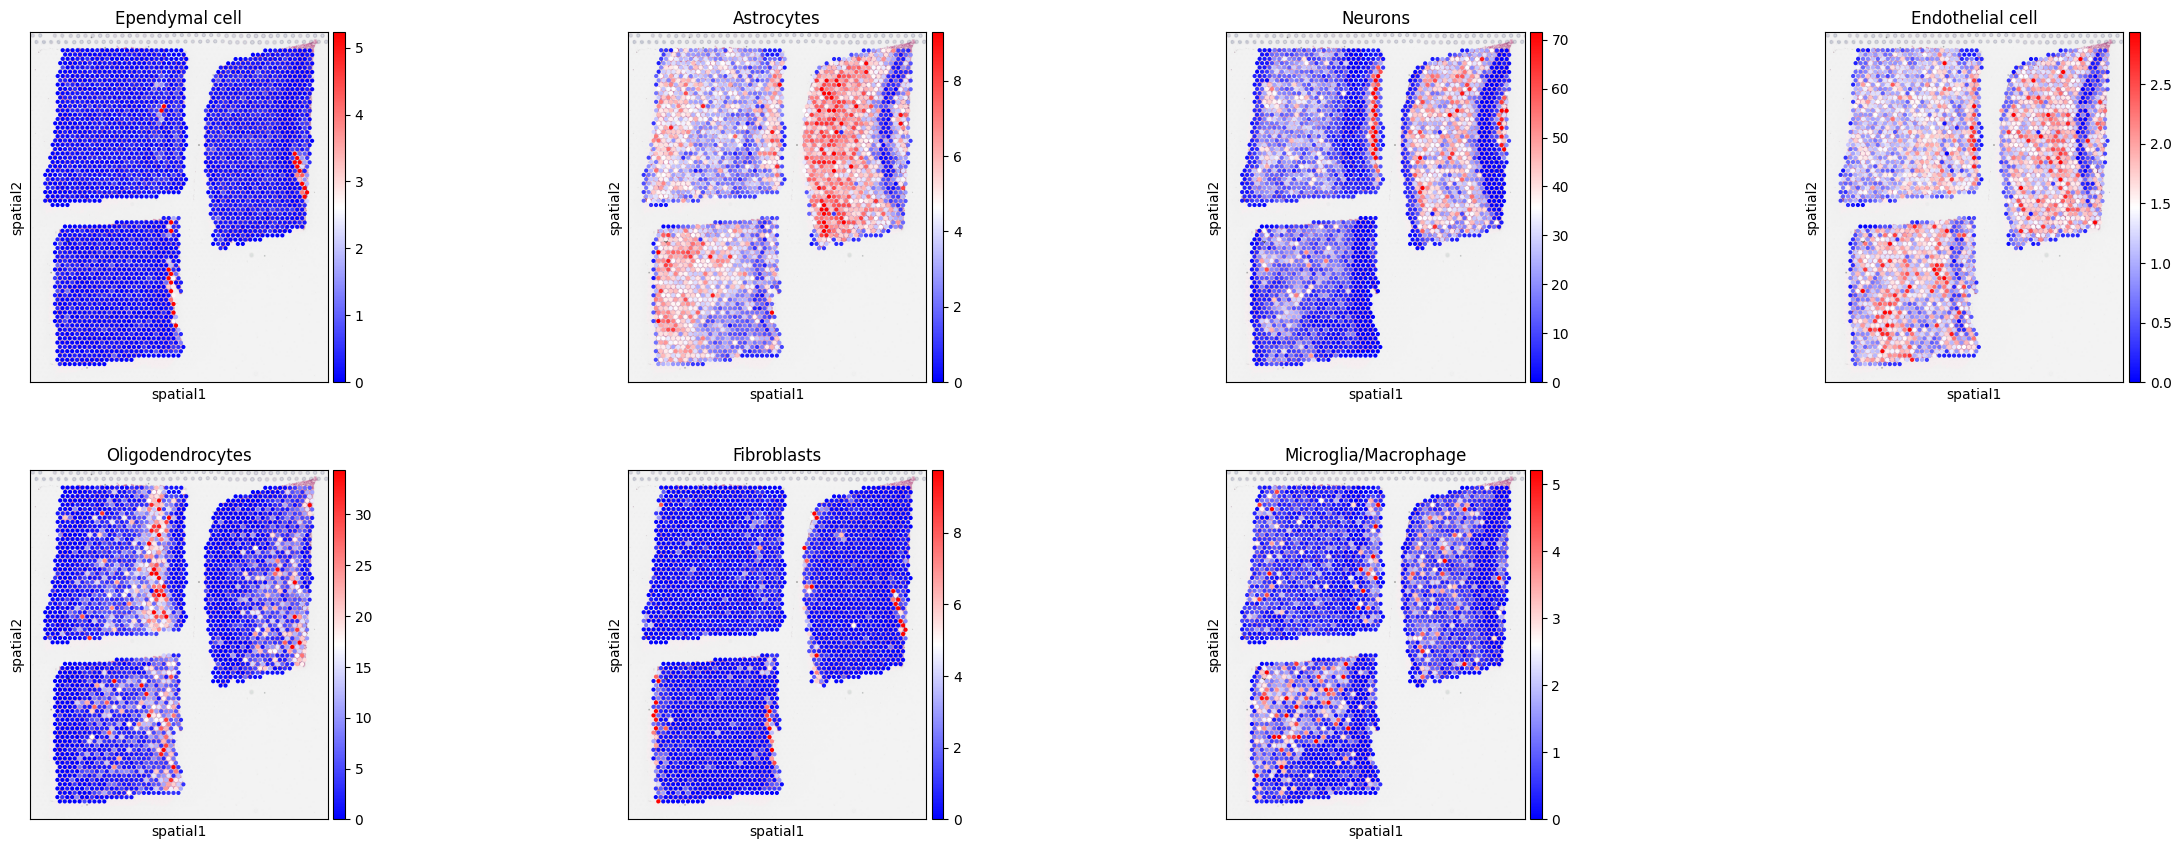

In [10]:
# 可视化
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# plot in spatial coordinates
cells = list(set(adata_ref.obs['sc_celltype']))

sc.pl.spatial(adata_vis, cmap = 'bwr', color = cells, ncols = 4, size = 1.3, img_key = 'hires', vmin =0, vmax = 'p99.2')

### 使用基质分解（NMF）识别细胞区室/组织区

In [11]:
# 读取数据
adata_vis = sc.read_h5ad('/home/zhangyinan/TXL_new/4_cell2location/Integrate/Control5_Model2_Treatment3/result/celltype/cell2location_map/sp.h5ad')

In [12]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_5combinations_2666locations_7factors
### Analysis name: CoLocatedGroupsSklearnNMF_6combinations_2666locations_7factors
### Analysis name: CoLocatedGroupsSklearnNMF_7combinations_2666locations_7factors
### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_23combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_24combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_26combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_27combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_28combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Analysis name: CoLocatedGroupsSklearnNMF_29combinations_2666locations_7factors


/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/anaconda3/envs/cell2loc_env_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


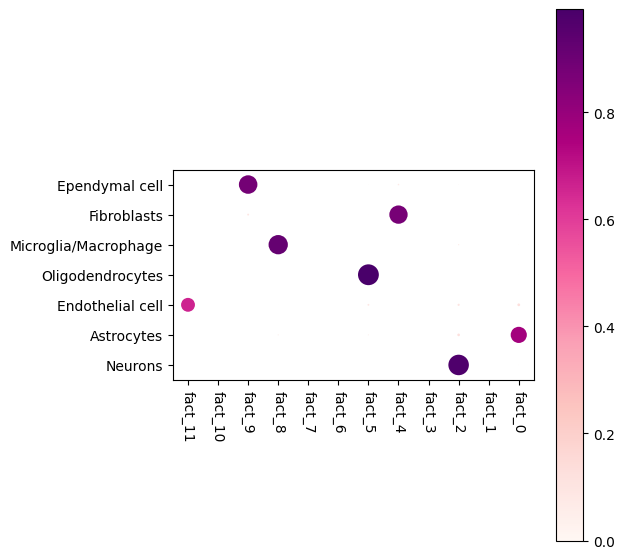

In [13]:
# 画图
res_dict['n_fact12']['mod'].plot_cell_type_loadings()